# Coursera IBM Applied Data Science Capstone Final Project

## Introduction:
### The following is an analysis of the different eateries in the city of Singapore

In this analysis, we will be taking a look at the neigborhoods of Singapore, particularly some of the neighborhoods located in the Eastern Region of the city-state i.e. neighborhoods located the closest to Changi Airport.

## Importing the necessary libraries

In [37]:
import numpy as np

import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

import json

from geopy.geocoders import Nominatim
import geocoder

import requests
from bs4 import BeautifulSoup
import requests

from pandas.io.json import json_normalize

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors


from sklearn.cluster import KMeans

import folium



## Using BeautifulSoup to scrape table from URL

In [2]:
URL='https://en.wikipedia.org/wiki/Planning_Areas_of_Singapore'
response = requests.get(URL)
soup = BeautifulSoup(response.text, 'html.parser')
# print(soup)
table = soup.find('table', {'class':'wikitable sortable'}).tbody
# print(table)
rows = table.find_all('tr')
columns = [v.text.replace('\n','') for v in rows[0].find_all('th')]
# print(columns)
df_singapore=pd.DataFrame(columns=columns)
for i in range(1,len(rows)):
    tds = rows[i].find_all('td')
    values = [td.text.replace('\n','') for td in tds]
    df_singapore = df_singapore.append(pd.Series(values, index=columns), ignore_index=True)
df_singapore.to_csv('singapore_planning_areas.csv',index=False)

## Displaying all neighborhoods in Singapore

In [13]:
df_singapore=pd.read_csv("singapore_planning_areas.csv")
df_singapore

,Name
0,Ang Mo Kio
1,Bedok
2,Bishan
3,Boon Lay
4,Bukit Batok
5,Bukit Merah
6,Bukit Panjang
7,Bukit Timah
8,Central Water Catchment
9,Changi


## Getting coordinates of each neighborhood

In [10]:
def get_coord(area):
    coords = None
    while(coords is None):
        g = geocoder.arcgis('{}, Singapore'.format(area))
        coords = g.latlng
    return coords

In [14]:
coor = [ get_coord(area) for area in df_singapore["Name"].tolist() ]

## Merging the coordinates dataset with the original dataset

In [15]:
df_coords = pd.DataFrame(coor, columns=['Latitude','Longitude'])

In [16]:
df_singapore['Latitude'] = df_coords['Latitude']
df_singapore['Longitude'] = df_coords['Longitude']

In [17]:
df_singapore.head()

,Name,Latitude,Longitude
0,Ang Mo Kio,1.37161,103.84546
1,Bedok,1.32425,103.95297
2,Bishan,1.35079,103.85110
3,Boon Lay,1.33333,103.70000
4,Bukit Batok,1.34952,103.75277


## Finding out the coordinates of Singapore

In [18]:
address = 'Singapore'

geolocator = Nominatim(user_agent="singapore_project")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Singapore are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Singapore are 1.357107, 103.8194992.


## Plotting neighborhoods on a map using Folium

In [19]:
map_singapore = folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, lng, neighborhood in zip(df_singapore['Latitude'], df_singapore['Longitude'], df_singapore['Name']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_singapore)  
    
map_singapore

#### NOTE: Not all areas have been taken into consideration. Some areas such as outlying islands have no civilian settlements or are military designated areas, hence they have not been considered for analysis. Additionally, some of the coordinates for the given areas may be skewed hence searched venues may differ.

## Declaring Foursquare Credentials

In [20]:
CLIENT_ID = 'XO2HZMVP4SMLWK25QZDZEGBS5JJV5GZLUOMKI1P1DAQEWNEY'
CLIENT_SECRET = '5HMXMHD21X3FLIHYL2T3NZZPTTM2QCX1CAE2C4E4AABEK3IE'
VERSION = '20180605' # Foursquare API version

print('Foursquare credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Foursquare credentials:
CLIENT_ID: XO2HZMVP4SMLWK25QZDZEGBS5JJV5GZLUOMKI1P1DAQEWNEY
CLIENT_SECRET:5HMXMHD21X3FLIHYL2T3NZZPTTM2QCX1CAE2C4E4AABEK3IE


## Getting all the nearby eateries for each neighbourhood using Foursquare API

In [22]:
radius = 2000
LIMIT = 50

venues = []

for lat, long, neighborhood in zip(df_singapore['Latitude'], df_singapore['Longitude'], df_singapore['Name']):
    
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&categoryId=4d4b7105d754a06374d81259&v={}&ll={},{}&radius={}&limit={}".format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        long,
        radius, 
        LIMIT)
  
    results = requests.get(url).json()["response"]['groups'][0]['items']

    for venue in results:
        venues.append((
            neighborhood,
            lat, 
            long, 
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name']))

In [23]:
resident_df = pd.DataFrame(venues)

resident_df.columns = ['Neighborhood', 'Latitude', 'Longitude', 'VenueName', 'VenueLatitude', 'VenueLongitude', 'VenueCategory']

print(resident_df.shape)
resident_df

(2440, 7)


,Neighborhood,Latitude,Longitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
0,Ang Mo Kio,1.371610,103.845460,Face Ban Mian 非板面 (Ang Mo Kio),1.372031,103.847504,Noodle House
1,Ang Mo Kio,1.371610,103.845460,Kam Jia Zhuang Restaurant,1.368167,103.844118,Asian Restaurant
2,Ang Mo Kio,1.371610,103.845460,Old Chang Kee,1.369094,103.848389,Snack Place
3,Ang Mo Kio,1.371610,103.845460,Subway,1.369136,103.847612,Sandwich Place
4,Ang Mo Kio,1.371610,103.845460,Xi Xiang Feng Yong Tau Foo 喜相逢酿豆腐,1.371975,103.846408,Chinese Restaurant
5,Ang Mo Kio,1.371610,103.845460,龍海鮮螃蟹王 Mellben Seafood,1.368324,103.836764,Seafood Restaurant
6,Ang Mo Kio,1.371610,103.845460,MOS Burger,1.369170,103.847831,Burger Joint
7,Ang Mo Kio,1.371610,103.845460,Bangkok Street Mookata,1.365688,103.853186,BBQ Joint
8,Ang Mo Kio,1.371610,103.845460,Boon Tong Kee 文東記,1.367917,103.836972,Chinese Restaurant
9,Ang Mo Kio,1.371610,103.845460,Lao San Kway Chap 老三棵汁·猪什汤,1.367916,103.837008,Chinese Restaurant


In [24]:
resident_df.groupby(["Neighborhood"]).count().head()

,Latitude,Longitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
Neighborhood,,,,,,
Ang Mo Kio,50,50,50,50,50,50
Bedok,50,50,50,50,50,50
Bishan,50,50,50,50,50,50
Boon Lay,50,50,50,50,50,50
Bukit Batok,50,50,50,50,50,50


In [25]:
print('There are {} uniques categories.'.format(len(resident_df['VenueCategory'].unique())))

There are 83 uniques categories.


## Categorising the eateries by types and counting the same

<BarContainer object of 83 artists>

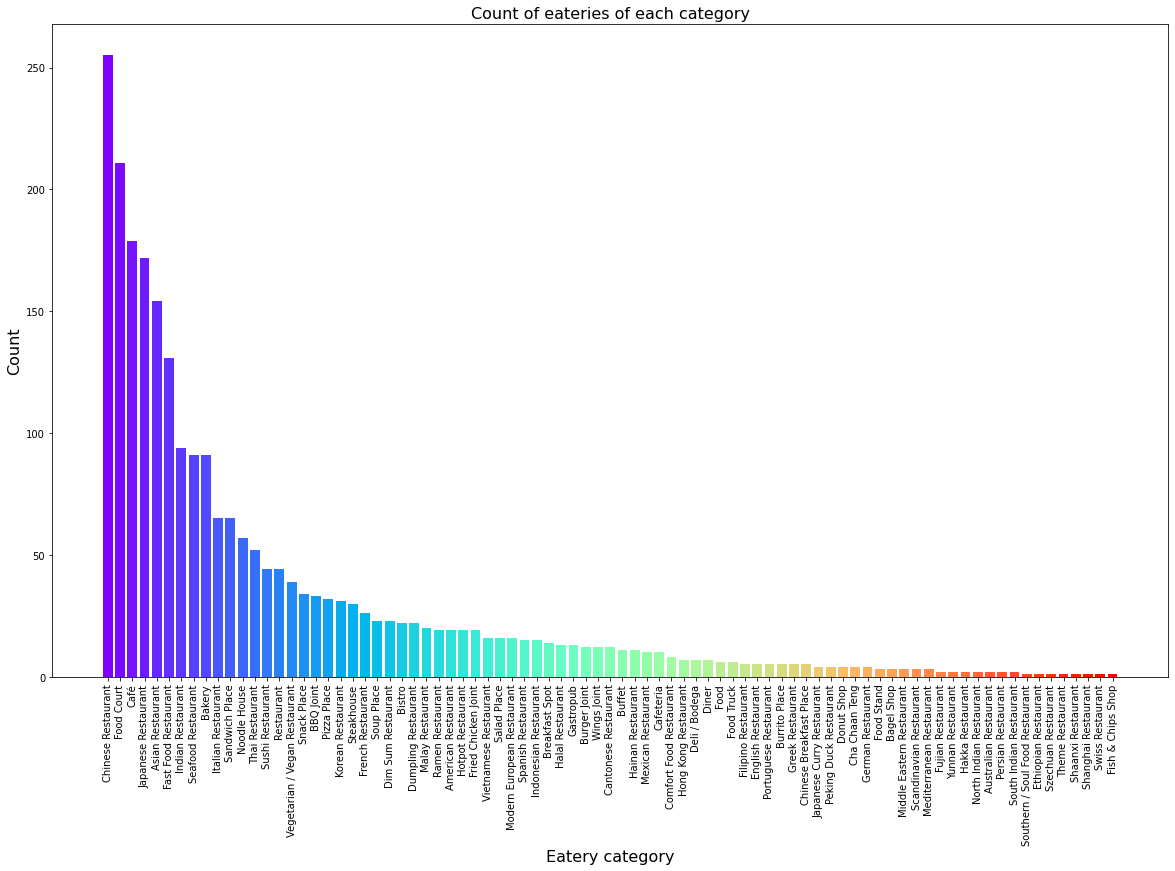

In [26]:
eateries_dist=resident_df['VenueCategory'].value_counts()
colors = cm.rainbow(np.linspace(0, 1, len(eateries_dist.index)))
plt.figure(figsize = (20, 12))
plt.xticks(rotation = 90)
plt.xlabel("Eatery category", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of eateries of each category", fontsize = 16)
plt.bar(eateries_dist.index, eateries_dist.values, color = colors)

There are 83 different categories of eateries in the city

## Selecting eateries located in the Eastern Suburbs (Bedok, Changi, Changi Bay, Geylang, Marina East, Marine Parade, Pasir Ris, Paya Lebar, Siglap and Tampines)

Here we have localized the data exclusively to the Eastern Suburbs which are Bedok, Changi, Changi Bay, Geylang, Marina East, Marine Parade, Pasir Ris, Paya Lebar, Siglap and Tampines. One reason for doing this is because the Airport is located in the Eastern Region of Singapore. This can be used to analyze which places are frequented by travellers, amongst the locals. Additionally, we get a picture of the demographical distribution by looking at the categories of the restaurants of a small dataframe, which can be used to predict the same for other regions.

In [27]:
df_eateries_east=resident_df.loc[resident_df['Neighborhood'].isin(['Bedok','Changi','Changi Bay','Pasir Ris','Siglap','Tampines','Marine Parade','Marina East','Paya Lebar','Geylang'])]
df_eateries_east

,Neighborhood,Latitude,Longitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
50,Bedok,1.32425,103.95297,58 Minced Meat Mee (Minced Pork Noodle) 58肉脞面 ...,1.324106,103.941222,Noodle House
51,Bedok,1.32425,103.95297,New Mahamoodiya Restaurant,1.331267,103.947671,Indian Restaurant
52,Bedok,1.32425,103.95297,Badoque Cafe,1.331426,103.948504,Café
53,Bedok,1.32425,103.95297,Huggs JPM @ Changi City (huggs coffee),1.334441,103.964183,Café
54,Bedok,1.32425,103.95297,Hua Yu Wee Restaurant,1.314572,103.941589,Chinese Restaurant
55,Bedok,1.32425,103.95297,The Burning Oak,1.331380,103.948312,BBQ Joint
56,Bedok,1.32425,103.95297,Turo Turo,1.335085,103.964109,Filipino Restaurant
57,Bedok,1.32425,103.95297,Fatty Fong Seafood Resturant,1.325251,103.940759,Seafood Restaurant
58,Bedok,1.32425,103.95297,Changi Lor 108 Fei Lao Seafood,1.332402,103.939209,Asian Restaurant
59,Bedok,1.32425,103.95297,CHAN B.B.Q,1.331829,103.938760,Seafood Restaurant


## Displaying all eateries in Eastern Singapore on a Map

In [28]:
map_singapore_eat_east = folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, lng, name in zip(df_eateries_east['VenueLatitude'], df_eateries_east['VenueLongitude'], df_eateries_east['VenueName']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_singapore_eat_east)  
    
map_singapore_eat_east

## Categorizing eateries in Eastern Singapore

<BarContainer object of 60 artists>

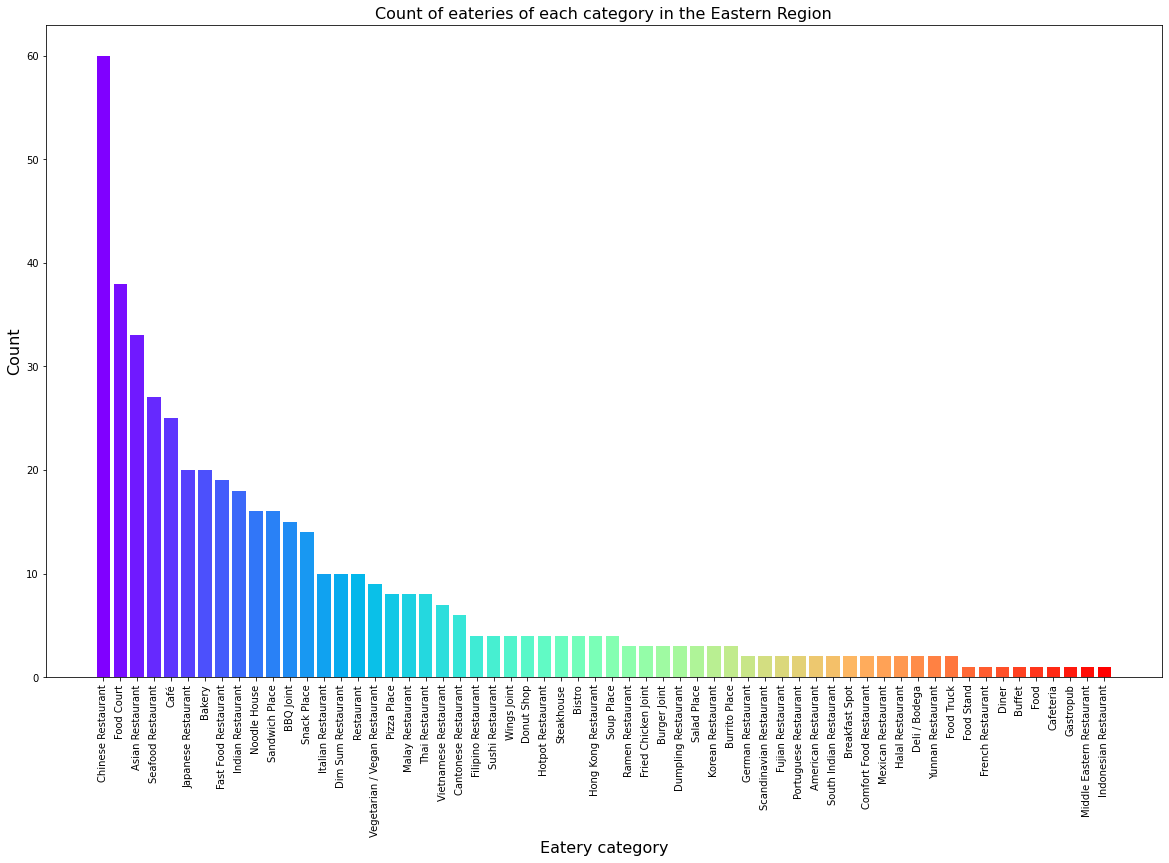

In [44]:
eateries_dist=df_eateries_east['VenueCategory'].value_counts()
colors = cm.rainbow(np.linspace(0, 1, len(eateries_dist.index)))
plt.figure(figsize = (20, 12))
plt.xticks(rotation = 90)
plt.xlabel("Eatery category", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of eateries of each category in the Eastern Region", fontsize = 16)
plt.bar(eateries_dist.index, eateries_dist.values, color = colors)

There are 57 different categories of eateries in the Eastern Suburbs

## Finding out the most popular eateries using one hot encoding

In [30]:
sg_east_onehot = pd.get_dummies(df_eateries_east[['VenueCategory']], prefix="", prefix_sep="")

sg_east_onehot['Neighborhood'] = df_eateries_east['Neighborhood'] 

fixed_columns = [sg_east_onehot.columns[-1]] + list(sg_east_onehot.columns[:-1])
sg_east_onehot = sg_east_onehot[fixed_columns]

sg_east_grouped = sg_east_onehot.groupby('Neighborhood').mean().reset_index()

# sg_east_onehot.head()
sg_east_grouped

,Neighborhood,American Restaurant,Asian Restaurant,BBQ Joint,Bakery,Bistro,Breakfast Spot,Buffet,Burger Joint,Burrito Place,Cafeteria,Café,Cantonese Restaurant,Chinese Restaurant,Comfort Food Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Fast Food Restaurant,Filipino Restaurant,Food,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Fujian Restaurant,Gastropub,German Restaurant,Halal Restaurant,Hong Kong Restaurant,Hotpot Restaurant,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Malay Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Noodle House,Pizza Place,Portuguese Restaurant,Ramen Restaurant,Restaurant,Salad Place,Sandwich Place,Scandinavian Restaurant,Seafood Restaurant,Snack Place,Soup Place,South Indian Restaurant,Steakhouse,Sushi Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint,Yunnan Restaurant
0,Bedok,0.00,0.060000,0.04,0.020000,0.00,0.02,0.00,0.00,0.00,0.000000,0.120000,0.00,0.140000,0.00,0.00,0.00,0.00,0.00,0.00,0.020000,0.02,0.00,0.120000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.00,0.020000,0.000000,0.000000,0.08,0.00,0.06,0.00,0.00,0.10,0.000000,0.00,0.00,0.000000,0.02,0.020000,0.000000,0.060000,0.000000,0.000000,0.02,0.02,0.000000,0.020000,0.000000,0.00,0.00,0.00
1,Changi,0.00,0.060000,0.04,0.080000,0.00,0.00,0.00,0.02,0.00,0.000000,0.060000,0.02,0.080000,0.00,0.00,0.02,0.00,0.04,0.00,0.060000,0.00,0.00,0.040000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.02,0.02,0.00,0.020000,0.000000,0.000000,0.06,0.00,0.02,0.00,0.00,0.00,0.000000,0.02,0.02,0.040000,0.00,0.100000,0.000000,0.020000,0.080000,0.000000,0.00,0.00,0.000000,0.020000,0.000000,0.00,0.02,0.02
2,Changi Bay,0.00,0.080000,0.02,0.080000,0.00,0.00,0.00,0.02,0.00,0.000000,0.060000,0.02,0.060000,0.00,0.00,0.02,0.00,0.04,0.00,0.060000,0.00,0.00,0.040000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.02,0.02,0.00,0.020000,0.000000,0.000000,0.08,0.00,0.02,0.00,0.00,0.00,0.000000,0.02,0.02,0.040000,0.00,0.100000,0.000000,0.020000,0.080000,0.000000,0.00,0.00,0.000000,0.020000,0.000000,0.00,0.02,0.02
3,Geylang,0.00,0.060000,0.08,0.000000,0.00,0.00,0.00,0.00,0.02,0.000000,0.040000,0.04,0.140000,0.00,0.00,0.06,0.00,0.00,0.00,0.020000,0.02,0.00,0.120000,0.000000,0.020000,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.02,0.000000,0.000000,0.000000,0.00,0.02,0.02,0.00,0.00,0.04,0.000000,0.00,0.00,0.000000,0.00,0.020000,0.000000,0.100000,0.020000,0.040000,0.00,0.00,0.000000,0.020000,0.040000,0.02,0.00,0.00
4,Marina East,0.00,0.020000,0.02,0.060000,0.04,0.00,0.00,0.00,0.00,0.000000,0.060000,0.02,0.100000,0.00,0.00,0.04,0.00,0.00,0.02,0.000000,0.00,0.02,0.020000,0.000000,0.000000,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.120000,0.000000,0.060000,0.08,0.02,0.02,0.00,0.00,0.04,0.020000,0.00,0.00,0.020000,0.02,0.000000,0.000000,0.060000,0.000000,0.000000,0.00,0.02,0.020000,0.000000,0.020000,0.04,0.00,0.00
5,Marine Parade,0.00,0.040000,0.00,0.060000,0.04,0.00,0.00,0.00,0.00,0.000000,0.020000,0.00,0.100000,0.00,0.02,0.04,0.00,0.00,0.02,0.020000,0.02,0.00,0.040000,0.000000,0.000000,0.00,0.00,0.02,0.00,0.02,0.00,0.00,0.00,0.120000,0.000000,0.040000,0.08,0.02,0.00,0.02,0.00,0.06,0.020000,0.00,0.00,0.020000,0.02,0.000000,0.000000,0.020000,0.020000,0.000000,0.00,0.02,0.020000,0.000000,0.020000,0.04,0.00,0.00
6,Pasir Ris,0.00,0.080000,0.00,0.020000,0.00,0.00,0.02,0.02,0.00,0.000000,0.040000,0.00,0.060000,0.02,0.00,0.00,0.02,0.00,0.00,0.140000,0.00,0.00,0.140000,0.000000,0.000000,0.00,0.02,0.00,0.02,0.00,0.00,0.02,0.02,0.000000,0.000000,0.040000,0.00,0.00,0.00,0.00,0.00,0.02,0.020000,0.00,0.00,0.040000,0.00,0.060000,0.020000,0.060000,0.020000,0.000000,0.00,0.02,0.020000,0.040000,0.000000,0.00,0.00,0.00
7,Paya Lebar,0.00,0.100000,0.08,0.000000,0.00,0.00,0.00,0.00,0.02,0.000000,0.060000,0.02,0.160000,0.00,0.00,0.02,0.00,0.00,0.02,0.020000,0.02,0.00,0.140000,0.000000,0.000000,0.00,0.02,0.00,0.00,0.02,0.00,0.00,0.02,0.000000,0.000000,0

## Defining function to retrieve top 10 eateries by neighbourhood

In [31]:
def return_most_common_eat(row, num_top_eat):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_eat]

In [33]:
num_top_eat = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_eat):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = sg_east_grouped['Neighborhood']

for ind in np.arange(sg_east_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_eat(sg_east_grouped.iloc[ind, :], num_top_eat)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bedok,Chinese Restaurant,Café,Food Court,Noodle House,Japanese Restaurant,Malay Restaurant,Asian Restaurant,Seafood Restaurant,BBQ Joint,Salad Place
1,Changi,Sandwich Place,Snack Place,Bakery,Chinese Restaurant,Japanese Restaurant,Café,Fast Food Restaurant,Asian Restaurant,Donut Shop,Restaurant
2,Changi Bay,Sandwich Place,Snack Place,Asian Restaurant,Japanese Restaurant,Bakery,Chinese Restaurant,Café,Fast Food Restaurant,Food Court,Donut Shop
3,Geylang,Chinese Restaurant,Food Court,Seafood Restaurant,BBQ Joint,Dim Sum Restaurant,Asian Restaurant,Noodle House,Cantonese Restaurant,Soup Place,Vegetarian / Vegan Restaurant
4,Marina East,Indian Restaurant,Chinese Restaurant,Japanese Restaurant,Bakery,Café,Italian Restaurant,Seafood Restaurant,Vietnamese Restaurant,Dim Sum Restaurant,Noodle House
5,Marine Parade,Indian Restaurant,Chinese Restaurant,Japanese Restaurant,Noodle House,Bakery,Italian Restaurant,Bistro,Food Court,Dim Sum Restaurant,Asian Restaurant
6,Pasir Ris,Food Court,Fast Food Restaurant,Asian Restaurant,Chinese Restaurant,Sandwich Place,Seafood Restaurant,Italian Restaurant,Café,Restaurant,Thai Restaurant
7,Paya Lebar,Chinese Restaurant,Food Court,Asian Restaurant,BBQ Joint,Seafood Restaurant,Café,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Cantonese Restaurant,Noodle House
8,Siglap,Chinese Restaurant,Seafood Restaurant,Asian Restaurant,Food Court,American Restaurant,Wings Joint,Indian Restaurant,Italian Restaurant,Pizza Place,Noodle House
9,Tampines,Chinese Restaurant,Asian Restaurant,Pizza Place,Food Court,Fast Food Restaurant,Bakery,Café,Snack Place,Seafood Restaurant,Indian Restaurant


## Clustering the Eastern neighborhoods by the most popular category of eateries

In [34]:
kclusters = 3

sg_east_grouped_clustering = sg_east_grouped.drop('Neighborhood', 1)

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(sg_east_grouped_clustering)

kmeans.labels_

array([0, 2, 2, 0, 1, 1, 2, 0, 0, 2])

In [39]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

sg_east_merged = df_singapore

sg_east_merged = sg_east_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Name')
sg_east_merged=sg_east_merged.dropna()
sg_east_merged

,Name,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Bedok,1.32425,103.95297,0.0,Chinese Restaurant,Café,Food Court,Noodle House,Japanese Restaurant,Malay Restaurant,Asian Restaurant,Seafood Restaurant,BBQ Joint,Salad Place
9,Changi,1.35514,103.99006,2.0,Sandwich Place,Snack Place,Bakery,Chinese Restaurant,Japanese Restaurant,Café,Fast Food Restaurant,Asian Restaurant,Donut Shop,Restaurant
10,Changi Bay,1.36996,103.99311,2.0,Sandwich Place,Snack Place,Asian Restaurant,Japanese Restaurant,Bakery,Chinese Restaurant,Café,Fast Food Restaurant,Food Court,Donut Shop
13,Geylang,1.31147,103.88218,0.0,Chinese Restaurant,Food Court,Seafood Restaurant,BBQ Joint,Dim Sum Restaurant,Asian Restaurant,Noodle House,Cantonese Restaurant,Soup Place,Vegetarian / Vegan Restaurant
20,Marina East,1.29579,103.89544,1.0,Indian Restaurant,Chinese Restaurant,Japanese Restaurant,Bakery,Café,Italian Restaurant,Seafood Restaurant,Vietnamese Restaurant,Dim Sum Restaurant,Noodle House
22,Marine Parade,1.30306,103.90778,1.0,Indian Restaurant,Chinese Restaurant,Japanese Restaurant,Noodle House,Bakery,Italian Restaurant,Bistro,Food Court,Dim Sum Restaurant,Asian Restaurant
28,Pasir Ris,1.37194,103.94994,2.0,Food Court,Fast Food Restaurant,Asian Restaurant,Chinese Restaurant,Sandwich Place,Seafood Restaurant,Italian Restaurant,Café,Restaurant,Thai Restaurant
29,Paya Lebar,1.32503,103.89049,0.0,Chinese Restaurant,Food Court,Asian Restaurant,BBQ Joint,Seafood Restaurant,Café,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Cantonese Restaurant,Noodle House
39,Siglap,1.31059,103.92540,0.0,Chinese Restaurant,Seafood Restaurant,Asian Restaurant,Food Court,American Restaurant,Wings Joint,Indian Restaurant,Italian Restaurant,Pizza Place,Noodle House
45,Tampines,1.36819,103.92948,2.0,Chinese Restaurant,Asian Restaurant,Pizza Place,Food Court,Fast Food Restaurant,Bakery,Café,Snack Place,Seafood Restaurant,Indian Restaurant


## Plotting the clusters on the map

In [40]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(sg_east_merged['Latitude'], sg_east_merged['Longitude'], sg_east_merged['Name'], sg_east_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Cluster 1

In [41]:
sg_east_merged.loc[sg_east_merged['Cluster Labels'] ==0].head()

,Name,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Bedok,1.32425,103.95297,0.0,Chinese Restaurant,Café,Food Court,Noodle House,Japanese Restaurant,Malay Restaurant,Asian Restaurant,Seafood Restaurant,BBQ Joint,Salad Place
13,Geylang,1.31147,103.88218,0.0,Chinese Restaurant,Food Court,Seafood Restaurant,BBQ Joint,Dim Sum Restaurant,Asian Restaurant,Noodle House,Cantonese Restaurant,Soup Place,Vegetarian / Vegan Restaurant
29,Paya Lebar,1.32503,103.89049,0.0,Chinese Restaurant,Food Court,Asian Restaurant,BBQ Joint,Seafood Restaurant,Café,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Cantonese Restaurant,Noodle House
39,Siglap,1.31059,103.92540,0.0,Chinese Restaurant,Seafood Restaurant,Asian Restaurant,Food Court,American Restaurant,Wings Joint,Indian Restaurant,Italian Restaurant,Pizza Place,Noodle House


This cluster consists of the suburbs of Bedok, Geylang, Siglap and Paya Lebar which are mainly dominated by public housing and residences, explaining the high presence of food courts and Chinese restaurants in the area

## Cluster 2

In [42]:
sg_east_merged.loc[sg_east_merged['Cluster Labels'] ==1].head()

,Name,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,Marina East,1.29579,103.89544,1.0,Indian Restaurant,Chinese Restaurant,Japanese Restaurant,Bakery,Café,Italian Restaurant,Seafood Restaurant,Vietnamese Restaurant,Dim Sum Restaurant,Noodle House
22,Marine Parade,1.30306,103.90778,1.0,Indian Restaurant,Chinese Restaurant,Japanese Restaurant,Noodle House,Bakery,Italian Restaurant,Bistro,Food Court,Dim Sum Restaurant,Asian Restaurant


This cluster consists of Marine Parade and Marina East areas, primarily consisting of shopping malls and other retail zones; various categories of eateries are prevalent here

## Cluster 3

In [43]:
sg_east_merged.loc[sg_east_merged['Cluster Labels'] ==2].head()

,Name,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,Changi,1.35514,103.99006,2.0,Sandwich Place,Snack Place,Bakery,Chinese Restaurant,Japanese Restaurant,Café,Fast Food Restaurant,Asian Restaurant,Donut Shop,Restaurant
10,Changi Bay,1.36996,103.99311,2.0,Sandwich Place,Snack Place,Asian Restaurant,Japanese Restaurant,Bakery,Chinese Restaurant,Café,Fast Food Restaurant,Food Court,Donut Shop
28,Pasir Ris,1.37194,103.94994,2.0,Food Court,Fast Food Restaurant,Asian Restaurant,Chinese Restaurant,Sandwich Place,Seafood Restaurant,Italian Restaurant,Café,Restaurant,Thai Restaurant
45,Tampines,1.36819,103.92948,2.0,Chinese Restaurant,Asian Restaurant,Pizza Place,Food Court,Fast Food Restaurant,Bakery,Café,Snack Place,Seafood Restaurant,Indian Restaurant


This cluster consists of the suburbs located the closest to the Airport; fast-food is prevalent here more than the other suburbs